---
# Acknowledgement

Portions of this notebook were generated with the assistance of generative AI and have been reviewed and modified by the authors.

---

In [14]:
import pandas as pd
import os
from pathlib import Path
from dotenv import find_dotenv
%load_ext dotenv
%dotenv          

# Set cwd to project root to allow access to file paths via os.getenv()
project_root = Path(find_dotenv()).resolve().parent
os.chdir(project_root)

df = pd.read_csv(f"{os.getenv('TRAIN_TEST_DATA_DIR')}/train.csv")

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [15]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.inspection import permutation_importance
from scipy.stats import entropy
from IPython.display import display

# Prepare X (train) & y (test)
train_df = df

X = (
    train_df.select_dtypes(include=[np.number])
    .drop(columns=["ACCIDENT_NO", "HIGH_SEVERITY", "SEVERITY"], errors="ignore")
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
)
y = train_df["HIGH_SEVERITY"]

# Compute random forest importances
rf = RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1)
rf.fit(X, y)
rf_imp = pd.Series(rf.feature_importances_, index=X.columns, name="rf_importance")

# Compute MI
mi = pd.Series(
    mutual_info_classif(X, y, random_state=42), index=X.columns, name="mutual_info"
)

# Compute NMI
def compute_entropy(feature_column):
    value_counts = pd.Series(feature_column).value_counts(normalize=True)
    return entropy(value_counts, base=2)


feature_entropies = X.apply(compute_entropy)
nmi = mi / feature_entropies
nmi = nmi.fillna(0).clip(0, 1)  # Ensure NMI stays between 0 and 1
nmi.name = "normalized_mi"

# Compute permutation importance
perm_result = permutation_importance(rf, X, y, n_repeats=10, random_state=42, n_jobs=-1)
perm_imp = pd.Series(
    perm_result.importances_mean, index=X.columns, name="permutation_importance"
)

# Combine all feature importance metrics
feat_stats = pd.concat([rf_imp, mi, nmi, perm_imp], axis=1).reset_index()
feat_stats = feat_stats.rename(columns={"index": "feature"})

# Display top features by each metric
metrics = {
    "RF Importance": rf_imp,
    "Mutual Information": mi,
    "Normalized MI": nmi,
    "Permutation Importance": perm_imp,
}

for name, series in metrics.items():
    print(f"Top 20 by {name}:")
    display(
        series.sort_values(ascending=False)
        .head(20)
        .to_frame(name.replace(" ", "_").lower())
    )

Top 20 by RF Importance:


,rf_importance
N_PERSONS,0.170812
YOUNGEST_DRIVER_BIN,0.165819
SPEED_KMH,0.159284
CLUSTER_ID,0.093799
NUM_VEHICLES,0.084089
DRIVER_FEMALE_PCT,0.066703
TIME_CAT_CODE,0.065251
WEEKEND,0.037839
IS_PEAK,0.022342
SURFACE_COND,0.017555


Top 20 by Mutual Information:


,mutual_information
NUM_VEHICLES,0.019632
WEATHER_1,0.018909
SURFACE_1,0.018202
SURFACE_COND,0.017361
IS_PEAK,0.014606
SPEED_KMH,0.010256
ATMOSPH_COND,0.010205
WEATHER_9,0.007809
DRIVER_FEMALE_PCT,0.007789
YOUNGEST_DRIVER_BIN,0.007649


Top 20 by Normalized MI:


,normalized_mi
WEATHER_3,0.121735
WEATHER_1,0.023592
SURFACE_1,0.022740
SURFACE_9,0.022283
WEATHER_9,0.017083
SURFACE_COND,0.015673
IS_PEAK,0.014655
NUM_VEHICLES,0.013336
SURFACE_3,0.011484
SURFACE_5,0.010825


Top 20 by Permutation Importance:


,permutation_importance
SPEED_KMH,0.125391
YOUNGEST_DRIVER_BIN,0.101983
NUM_VEHICLES,0.095101
N_PERSONS,0.094475
DRIVER_FEMALE_PCT,0.085359
CLUSTER_ID,0.058698
WEEKEND,0.056318
TIME_CAT_CODE,0.055726
IS_PEAK,0.030565
ANY_TRAILER,0.012089


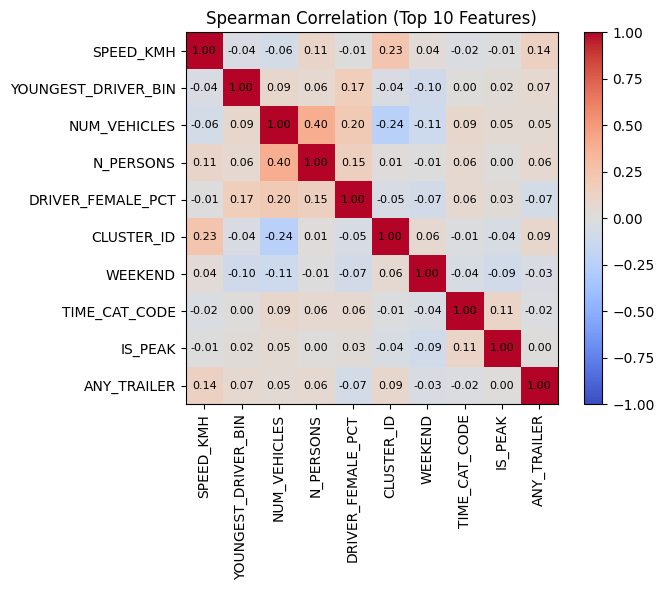

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Pick top features from permutation importance
top_feats = perm_imp.sort_values(ascending=False).head(10).index.tolist()

# Compute Spearman correlations
corr = X[top_feats].corr(method="spearman")

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)

# Tick labels
ax.set_xticks(np.arange(len(top_feats)))
ax.set_yticks(np.arange(len(top_feats)))
ax.set_xticklabels(top_feats, rotation=90)
ax.set_yticklabels(top_feats)

# Annotate each cell with the correlation value
for i in range(len(top_feats)):
    for j in range(len(top_feats)):
        ax.text(
            j,
            i,
            f"{corr.iloc[i, j]:.2f}",
            ha="center",
            va="center",
            color="black",
            fontsize=8,
        )

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Spearman Correlation (Top 10 Features)")
plt.tight_layout()
#plt.savefig("../figures/spearman_correlation.png")
plt.show()

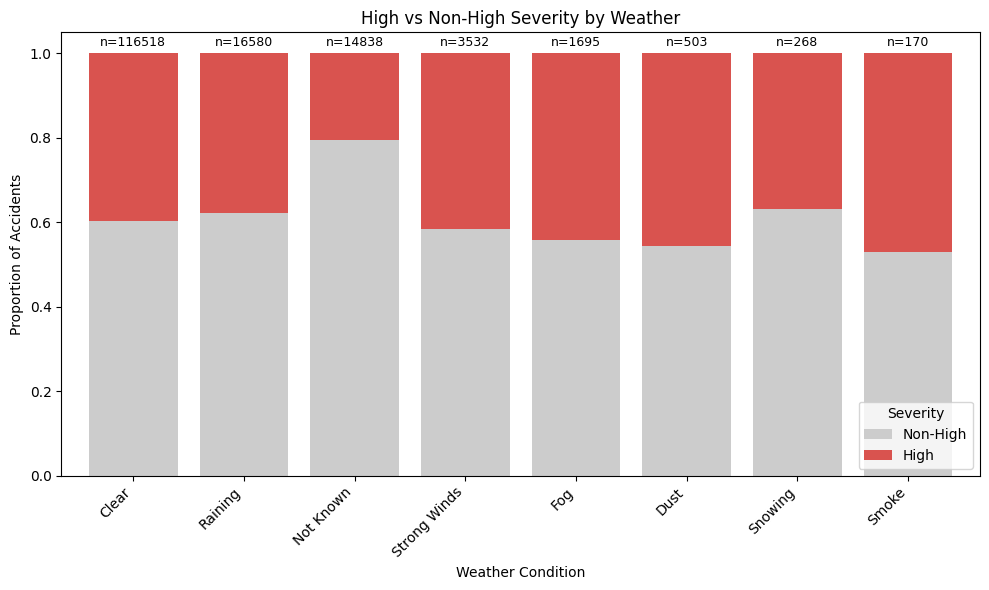

In [17]:
# Identify one-hot columns
weather_cols = [c for c in df.columns if c.startswith("WEATHER_")]

# Create a mapping from the one-hot column names to readable labels
weather_labels = {
    "WEATHER_1": "Clear",
    "WEATHER_2": "Raining",
    "WEATHER_3": "Snowing",
    "WEATHER_4": "Fog",
    "WEATHER_5": "Smoke",
    "WEATHER_6": "Dust",
    "WEATHER_7": "Strong Winds",
    "WEATHER_9": "Not Known",
}

# Melt into long form and keep only rows where the weather condition is "on"
df_w = df.melt(
    id_vars="HIGH_SEVERITY",
    value_vars=weather_cols,
    var_name="weather",
    value_name="present",
)
df_w = df_w[df_w["present"] == 1].drop(columns="present")

# Map to readable weather labels
df_w["weather"] = df_w["weather"].map(weather_labels)

# Count per weather × severity
counts = (
    df_w.groupby(["weather", "HIGH_SEVERITY"])
    .size()
    .unstack(fill_value=0)
    .rename(columns={0: "non_high", 1: "high"})
)

# Compute proportions
props = counts.div(counts.sum(axis=1), axis=0)

# Sort by total counts (descending)
total_counts = counts.sum(axis=1)
sorted_order = total_counts.sort_values(ascending=False).index
props = props.loc[sorted_order]
counts = counts.loc[sorted_order]  # Keep counts aligned for annotation

# Plot a stacked bar chart with readable labels
ax = props.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    color=["#CCCCCC", "#D9534F"],  #  light grey / red
    width=0.8,
)

# Add raw total counts above each bar
for idx, value in enumerate(total_counts.loc[sorted_order]):
    ax.text(
        idx,
        1.01,  # Slightly above the bar
        f"n={value}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

# Final plot adjustments
ax.set_ylabel("Proportion of Accidents")
ax.set_xlabel("Weather Condition")
ax.set_title("High vs Non-High Severity by Weather")
ax.legend(["Non-High", "High"], title="Severity", loc="lower right")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
#plt.savefig("../figures/severity_by_weather.png")
plt.show()

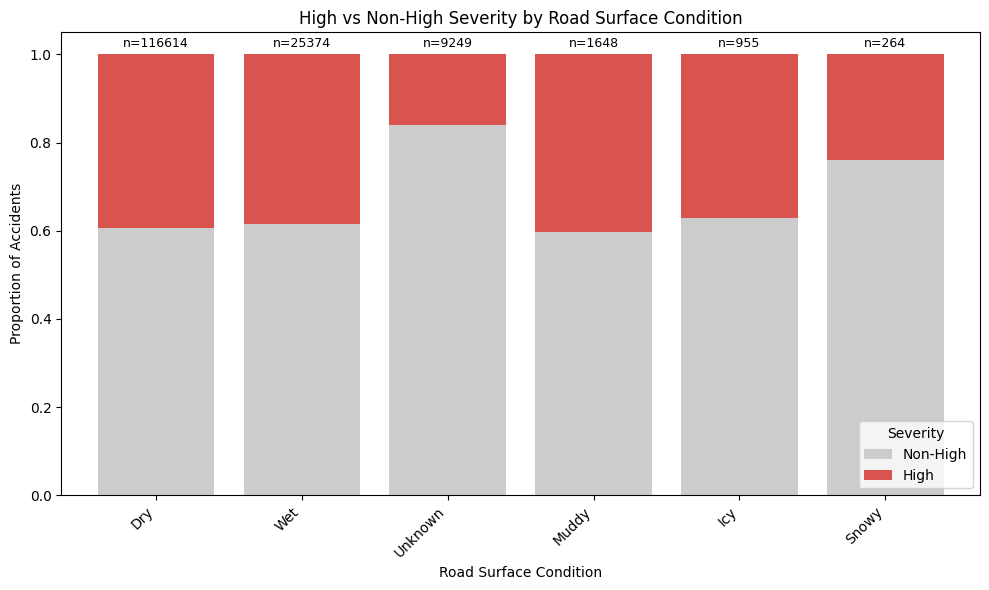

In [18]:
import matplotlib.pyplot as plt

# Create a mapping for surface condition codes to descriptive labels
surface_labels = {
    1: "Dry",
    2: "Wet",
    3: "Muddy",
    4: "Snowy",
    5: "Icy",
    9: "Unknown",
}

# Map the SURFACE_COND column to descriptive labels
df["SURFACE_COND_LABEL"] = df["SURFACE_COND"].map(surface_labels)

# Compute counts per surface condition × severity
counts = (
    df.groupby(["SURFACE_COND_LABEL", "HIGH_SEVERITY"])
    .size()
    .unstack(fill_value=0)
    .rename(columns={0: "non_high", 1: "high"})
)

# Compute proportions
props = counts.div(counts.sum(axis=1), axis=0)

# Sort by total counts (descending)
total_counts = counts.sum(axis=1)
sorted_order = total_counts.sort_values(ascending=False).index
props = props.loc[sorted_order]
counts = counts.loc[sorted_order]  

# Plot stacked bars
ax = props.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    color=["#CCCCCC", "#D9534F"],  # light grey / red
    width=0.8,
)

# Add raw total counts above each bar
for idx, value in enumerate(total_counts.loc[sorted_order]):
    ax.text(
        idx,
        1.01, 
        f"n={value}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

# Final plot adjustments
ax.set_ylabel("Proportion of Accidents")
ax.set_xlabel("Road Surface Condition")
ax.set_title("High vs Non-High Severity by Road Surface Condition")
ax.legend(["Non-High", "High"], title="Severity", loc="lower right")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
#plt.savefig("../figures/severity_by_road_surface.png")
plt.show()

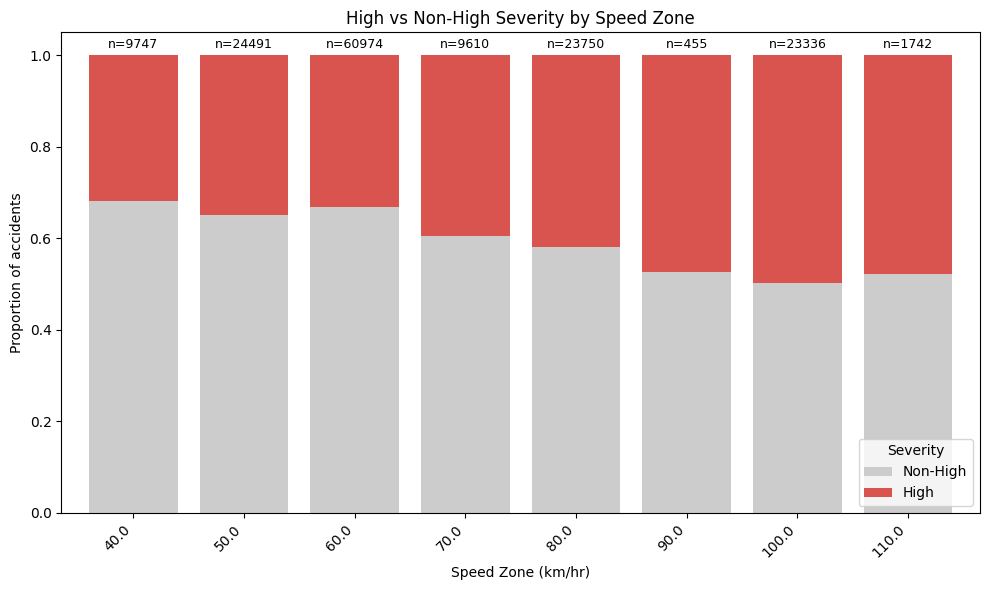

In [19]:
import matplotlib.pyplot as plt

# Count by driver‐bin and severity
counts = (
    df.groupby(["SPEED_KMH", "HIGH_SEVERITY"])
    .size()
    .unstack(fill_value=0)
    .rename(columns={0: "non_high", 1: "high"})
)

# Normalize so each bar sums to 1
props = counts.div(counts.sum(axis=1), axis=0)

# Plot a 100% stacked bar chart
ax = props.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    color=["#CCCCCC", "#D9534F"],  #  light grey / red
    width=0.8,
)

# Add raw total counts above each bar
total_counts = counts.sum(axis=1)
for idx, value in enumerate(total_counts):
    ax.text(
        idx,
        1.01, 
        f"n={value}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

ax.set_ylabel("Proportion of accidents")
ax.set_xlabel("Speed Zone (km/hr)")
ax.set_title("High vs Non-High Severity by Speed Zone")
ax.legend(["Non-High", "High"], title="Severity", loc="lower right")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
#plt.savefig("../figures/severity_by_speedzone.png")
plt.show()

C:\Users\jackp\AppData\Local\Temp\ipykernel_4308\1048535137.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["YOUNGEST_DRIVER_LABEL", "HIGH_SEVERITY"])


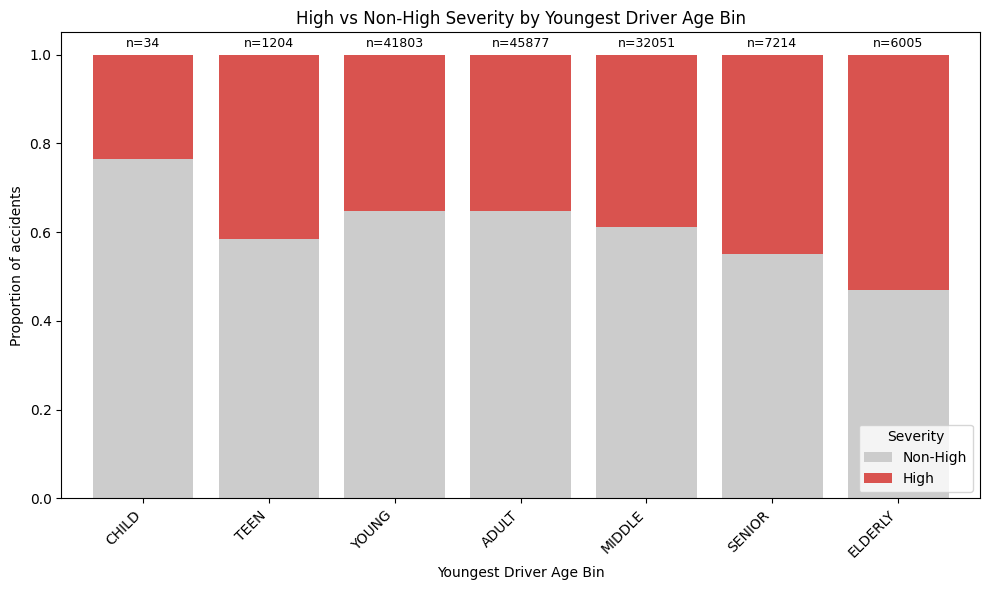

In [20]:
# Define code -> label map 
inv_map = {
    0: "CHILD",
    1: "TEEN",
    2: "YOUNG",
    3: "ADULT",
    4: "MIDDLE",
    5: "SENIOR",
    6: "ELDERLY",
}

# Map the code back to a label
df["YOUNGEST_DRIVER_LABEL"] = df["YOUNGEST_DRIVER_BIN"].map(inv_map)

# Make it an ordered categorical (so the bars go CHILD -> ... -> ELDERLY)
age_order = ["CHILD", "TEEN", "YOUNG", "ADULT", "MIDDLE", "SENIOR", "ELDERLY"]
df["YOUNGEST_DRIVER_LABEL"] = pd.Categorical(
    df["YOUNGEST_DRIVER_LABEL"],
    categories=age_order,
    ordered=True,
)

# Recompute counts & proportions, grouping on the new label
counts = (
    df.groupby(["YOUNGEST_DRIVER_LABEL", "HIGH_SEVERITY"])
    .size()
    .unstack(fill_value=0)
    .rename(columns={0: "non_high", 1: "high"})
)
props = counts.div(counts.sum(axis=1), axis=0)

# Plot 
ax = props.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    color=["#CCCCCC", "#D9534F"],
    width=0.8,
)

total_counts = counts.sum(axis=1)
for idx, value in enumerate(total_counts):
    ax.text(idx, 1.01, f"n={value}", ha="center", va="bottom", fontsize=9)

ax.set_ylabel("Proportion of accidents")
ax.set_xlabel("Youngest Driver Age Bin")
ax.set_title("High vs Non-High Severity by Youngest Driver Age Bin")
ax.legend(["Non-High", "High"], title="Severity", loc="lower right")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
#plt.savefig("../figures/severity_by_youngest_driver_bin.png")
plt.show()

# Save Truncated Data (Top 10 Features Only)

In [21]:
df = pd.read_csv(f"{os.getenv('TRAIN_TEST_DATA_DIR')}/train.csv")
# Pick top features from permutation importance
top_feats = perm_imp.sort_values(ascending=False).head(10).index.tolist()
relevant_cols = top_feats + ["HIGH_SEVERITY"]
output_df = df[relevant_cols]
output_df.to_csv(f"{os.getenv('TRAIN_TEST_DATA_DIR')}/top_10_train.csv", index=False)